# Colours project

Objectives:

    1) Extract the most predominant colour(s) in an image with various methods
        a) total RGB mode
        b) ?
    2) Arrange the images by their RGB colours similarities

In [18]:
from PIL import Image #Python Imaging Library

import sys

import shutil
import os

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
def RGB_histogram(values, name):
    if not os.path.isdir("histograms"):
        os.makedirs("histograms")
    f = plt.figure(figsize=(15,10))
    plt.grid()
    color = ('firebrick','mediumseagreen','royalblue')
    for i,col in enumerate(color):
        plt.hist(np.array(values)[:,i], color = col, histtype = 'stepfilled', 
                     bins = 256, alpha = 0.6)
    plt.xlim([0,256])
    plt.title("RGB contributions for "+ name)
    plt.ylabel("Frequency")
    plt.xlabel("Contribution to the pixels")
    plt.savefig("histograms/RGB_contribution_" + name + ".png")

In [20]:
def multiple_images(img, outputname):
    images = [Image.open(x) for x in img]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
        new_im.save(outputname +'.jpg')

In [21]:
def RGB_image(values, path, outputname, img, size):
    if not os.path.isdir("RGBcomposites"):
        os.makedirs("RGBcomposites")
        
    r = [(d[0], 0, 0) for d in values]
    g = [(0, d[1], 0) for d in values]
    b = [(0, 0, d[2]) for d in values]
    
    if not os.path.isdir("rgb"):
        os.makedirs("rgb")
    
    width, height = size
    new_img = Image.new('RGB', (width, height))
    new_img.putdata(r)
    new_img.save('rgb/Rgb.jpg')
    new_img.putdata(g)
    new_img.save('rgb/rGb.jpg')
    new_img.putdata(b)
    new_img.save('rgb/rgB.jpg')
    
    I = [path, 'rgb/Rgb.jpg', 'rgb/rGb.jpg', 'rgb/rgB.jpg']
    final = multiple_images(I, "RGBcomposites/" + outputname)
    shutil.rmtree("rgb")
    return(final)

In [22]:
def colors_plot(colors, size, img, name, path):
    
    if not os.path.isdir("ColorPalette"):
        os.makedirs("ColorPalette")
    
    sample = []
    number = len(colors)
    
    width, height = size
    
    for c in colors:
        sample = sample + ([c] * round(width*height/number))
        
    new_img = Image.new('RGB', (width, height))
    new_img.putdata(sample)
    new_img.save('palette.jpg')
    
    images = [Image.open(x) for x in [path, 'palette.jpg']]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
        new_im.save('ColorPalette/ColorPalette_' + name +'.jpg')
    os.remove('palette.jpg')

In [23]:
import binascii
import struct
import scipy
import scipy.misc
import scipy.cluster

def ColorClustering(num_cluster, image):
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

    codes, dist = scipy.cluster.vq.kmeans(ar, num_cluster)
    codes = np.around(codes)
    codes = codes.astype(int)
    final = list(map(tuple, codes))
    return(final)

In [24]:
class ImageAnalizer(object):
    
    def __init__(self, path):
        self.path = path
        self.name = path.split(".", 1)[0]
        self.img = Image.open(path)
        self.pix = self.img.load()
        self.size = self.img.size
        self.total_pixels = self.size[0]*self.size[1]
        self.pixel_values = list(self.img.getdata())
        self.colors = sorted(self.img.getcolors(self.total_pixels), key = lambda tup: tup[0], 
                             reverse = True)
        
    def RGB_graph(self):
        return(RGB_histogram(self.pixel_values, self.name))
    
    def RGB_composite(self):
         return(RGB_image(self.pixel_values, self.path, 'RGB_composite_' + self.name +'.jpg', self.img, self.size))
        
    def Color_palette(self, colors):
        return(colors_plot(colors, self.size, self.img, self.name, self.path))


In [25]:
Imagen = ImageAnalizer("ceb.jpg")

In [26]:
Imagen.RGB_composite()

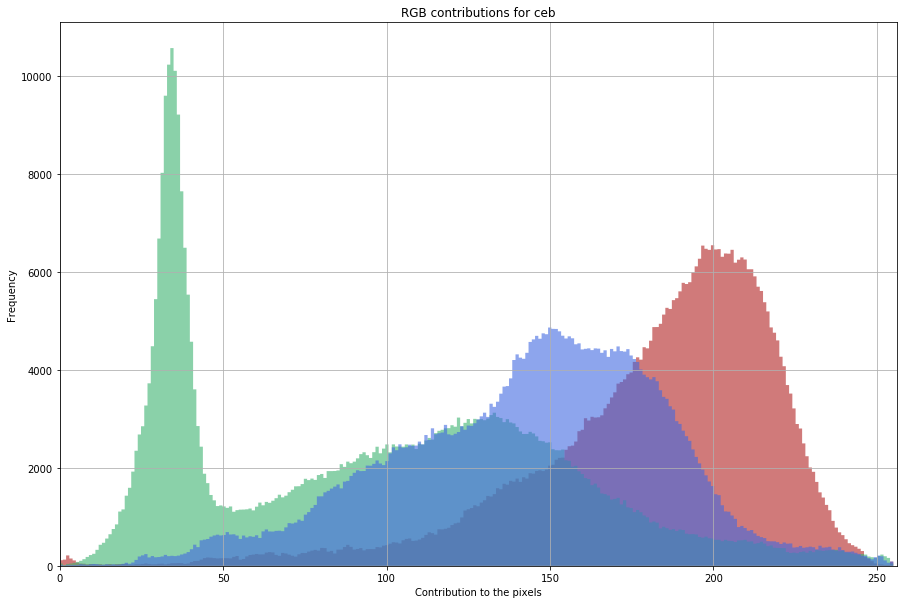

In [27]:
Imagen.RGB_graph()

In [29]:
Imagen.Color_palette(ColorClustering(10, Imagen.img))